In [1577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [1578]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [1579]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
    # plt.legend()

In [1580]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [1581]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [1582]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [1583]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [1584]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [1585]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [1586]:
from shapely.geometry import LineString, Polygon, Point

def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    if line.intersects(obstacle):
      return True

  return False

In [1587]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Generate Intermediate Point

In [1588]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, points in obstacles.items():
        pt1 = points[0]
        pt2 = points[1]
        coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
        obstacle = Polygon(coord)
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))

    # If no intersections found, return None
    if not intersections:
        return None

    # Calculate distances from each intersection to A and B
    distances = {}
    for inter in intersections:
        dist_to_a = math.sqrt(((inter.x - point_a[0]) ** 2) + ((inter.y - point_a[1]) ** 2))
        dist_to_b = math.sqrt(((inter.x - point_b[0]) ** 2) + ((inter.y - point_b[1]) ** 2))
        distances[inter] = dist_to_a + dist_to_b

    # Choose the intersection with the smallest sum of distances to A and B
    nearest_inter = min(distances, key=distances.get)

    # Check if there's a clear path along either side of the obstacle
    left_side = LineString([point_a, Point(nearest_inter.x - 0.5, nearest_inter.y)])
    right_side = LineString([point_a, Point(nearest_inter.x + 0.5, nearest_inter.y)])
    if not (left_side.intersects(obstacle) or right_side.intersects(obstacle)):
        # Choose the side that leads closer to B
        if left_side.distance(Point(point_b[0], point_b[1])) < right_side.distance(Point(point_b[0], point_b[1])):
            new_point = Point(nearest_inter.x - 0.5, nearest_inter.y)
        else:
            new_point = Point(nearest_inter.x + 0.5, nearest_inter.y)
        return [new_point.x, new_point.y]

    # If no clear path on either side, find the nearest corner of the obstacle
    obstacle_corners = [points[0], points[1], points[2], points[3]]
    nearest_corner = min(obstacle_corners, key=lambda corner: math.sqrt(((corner[0] - nearest_inter.x) ** 2) + ((corner[1] - nearest_inter.y) ** 2)))

    # Check if both offset points along the y-axis are not inside the obstacle
    sol_1 = Point([nearest_corner[0], nearest_corner[1] + 0.5])
    sol_2 = Point([nearest_corner[0], nearest_corner[1] - 0.5])
    if not (sol_1.intersects(obstacle) and sol_2.intersects(obstacle)):
        # Choose the offset point closer to B
        if sol_1.distance(Point(point_b[0], point_b[1])) < sol_2.distance(Point(point_b[0],point_b[1])):
            return [sol_1.x, sol_1.y]
        else:
            return [sol_2.x, sol_2.y]

    # If no acceptable solution found, return None
    return None

In [1589]:
def adv_route(route, dp, obstacles):
    for i in range(len(route)):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            route.insert(i+1, intermediate_point)
            route.insert(i+3, intermediate_point)
    return route

## Creation of New DP

In [1590]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if ls2[i] == pt1:
            ls2[i] = pt2

    return ls2

In [1591]:
def create_polygon(points):
    pt1 = points[0]
    pt2 = points[1]
    coord = [[pt1[0],pt1[1]], [pt2[0],pt1[1]], [pt2[0], pt2[1]], [pt1[0], pt2[1]], [pt1[0],pt1[1]]]
    obstacle = Polygon(coord)
    return obstacle

In [1592]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [1593]:
def calculate_obstacle_free_dp(delivery_loc, obstacles):
    # Create Shapely objects for efficient geometric calculations
    delivery_points = [Point(x, y) for x, y in delivery_loc]
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}

    # Initialize potential DP locations (covering the delivery point area)
    min_x, max_x, min_y, max_y = float('inf'), float('-inf'), float('inf'), float('-inf')
    for point in delivery_points:
        min_x = min(min_x, point.x)
        max_x = max(max_x, point.x)
        min_y = min(min_y, point.y)
        max_y = max(max_y, point.y)

    potential_dps = []
    for x in frange(min_x, max_x, 0.5):
        for y in frange(min_y, max_y, 0.5):
            potential_dps.append([x, y])

    # Evaluate each potential DP and filter out those obstructed by obstacles
    accessible_dps = []
    for dp in potential_dps:
        dp_point = Point(*dp)
        is_reachable = True
        for obstacle_id, obstacle in obstacle_polygons.items():
            # Check if any obstacle intersects the straight line from dp to each delivery point
            for delivery_point in delivery_points:
                line = LineString([dp_point, delivery_point])
                if line.intersects(obstacle):
                    is_reachable = False
                    break
            if not is_reachable:  # Early break if obstructed by any obstacle
                break
        if is_reachable:
            accessible_dps.append(dp)

    # Choose the DP with minimum average distance to delivery points (for efficiency)
    if not accessible_dps:
        raise ValueError("No obstacle-free DP location found!")

    best_dp = accessible_dps[0]
    min_avg_distance = float('inf')
    for dp in accessible_dps:
        total_distance = 0
        for delivery_point in delivery_points:
            total_distance += euc_distance(dp, [delivery_point.x, delivery_point.y])
        avg_distance = total_distance / len(delivery_points)
        if avg_distance < min_avg_distance:
            min_avg_distance = avg_distance
            best_dp = dp

    return best_dp

## Main

In [1594]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 5

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

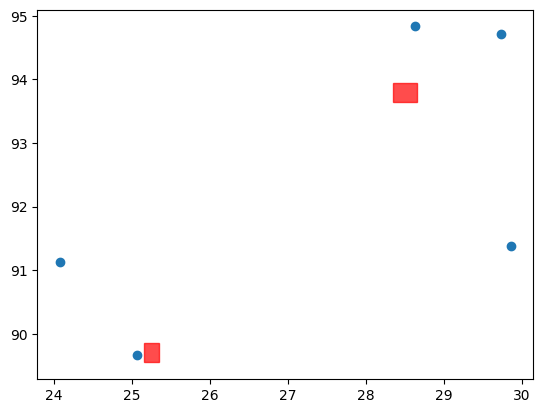

In [1595]:
# creating obstacles
obstacles = {
    0 : [[28.35, 93.65],[28.65, 93.95]],
    1 : [[25.15, 89.55],[25.35, 89.85]]
}

primary_plot(delivary_loc, obstacles)

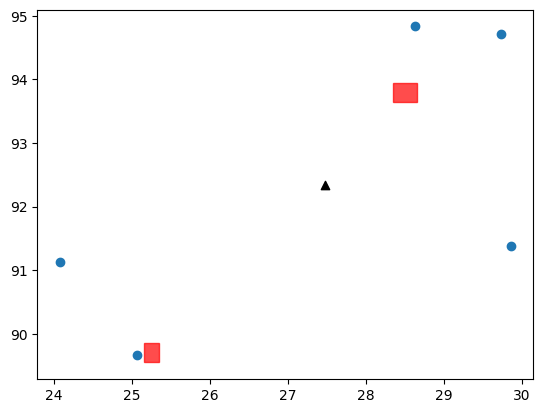

In [1596]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [1597]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[27.468798443589794, 92.3449733160866] -> [28.620969115553645, 94.8329697721627] -> [27.468798443589794, 92.3449733160866] -> [24.076340326872693, 91.136353901044] -> [27.468798443589794, 92.3449733160866] -> [25.064238436093373, 89.66337531936362] -> [27.468798443589794, 92.3449733160866] -> [29.857162367218038, 91.37484445635569] -> [27.468798443589794, 92.3449733160866] -> [29.72528197221123, 94.71732313150693] -> [27.468798443589794, 92.3449733160866] -> End


Initial Distance : 31.593837121627477


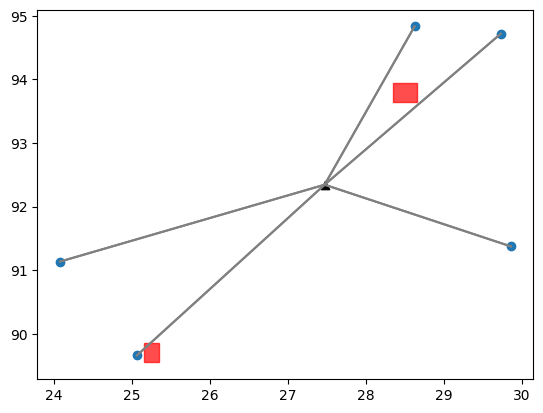

In [1598]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

Obstacle avoidance =>
Dp = [27.468798443589794, 92.3449733160866]
Route = [[27.468798443589794, 92.3449733160866], [28.620969115553645, 94.8329697721627], [27.468798443589794, 92.3449733160866], [24.076340326872693, 91.136353901044], [27.468798443589794, 92.3449733160866], [24.731582774811706, 89.85], [25.064238436093373, 89.66337531936362], [24.731582774811706, 89.85], [27.468798443589794, 92.3449733160866], [29.857162367218038, 91.37484445635569], [27.468798443589794, 92.3449733160866], [29.72528197221123, 94.71732313150693], [27.468798443589794, 92.3449733160866]]
Total distance = 32.56047931696055
--------------------------------------------------
Relocation of DP =>
Dp = [26.5763, 93.1634]
Route = [[26.5763, 93.1634], [28.620969115553645, 94.8329697721627], [26.5763, 93.1634], [24.076340326872693, 91.136353901044], [26.5763, 93.1634], [25.064238436093373, 89.66337531936362], [26.5763, 93.1634], [29.857162367218038, 91.37484445635569], [26.5763, 93.1634], [29.72528197221123, 94.717

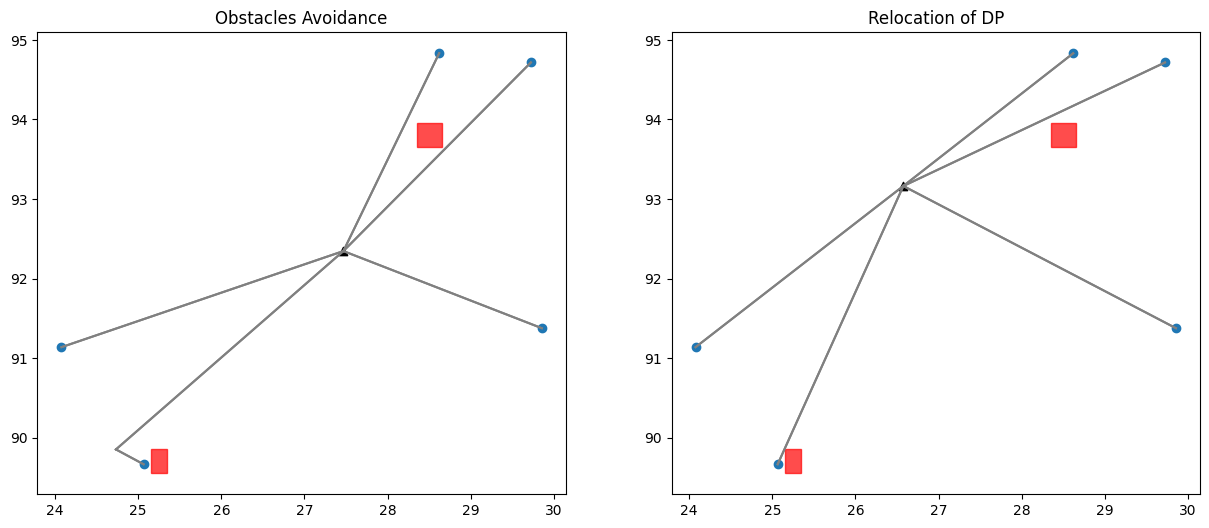

Optimal dp : [27.468798443589794, 92.3449733160866]
Optimal route : [[27.468798443589794, 92.3449733160866], [28.620969115553645, 94.8329697721627], [27.468798443589794, 92.3449733160866], [24.076340326872693, 91.136353901044], [27.468798443589794, 92.3449733160866], [24.731582774811706, 89.85], [25.064238436093373, 89.66337531936362], [24.731582774811706, 89.85], [27.468798443589794, 92.3449733160866], [29.857162367218038, 91.37484445635569], [27.468798443589794, 92.3449733160866], [29.72528197221123, 94.71732313150693], [27.468798443589794, 92.3449733160866]]


In [1599]:
THRESHOLD = initial_dist + (initial_dist*0.03)

if(detect_obstacle(initial_route, obstacles)):

    # obstacle avoidance
    temp_route = initial_route.copy()
    new_route = adv_route(temp_route, initial_dp, obstacles)
    new_dist = total_dist(new_route)
    print("Obstacle avoidance =>")
    print("Dp =",initial_dp)
    print("Route =",new_route)
    print("Total distance =",new_dist)
    print("-"*50)

    # locate new dp
    new_dp = calculate_obstacle_free_dp(delivary_loc, obstacles)
    final_route = replace(initial_route, initial_dp, new_dp)
    final_dist = total_dist(final_route)
    print("Relocation of DP =>")
    print("Dp =",new_dp)
    print("Route =",final_route)
    print("Total distance =",final_dist)
    print("-"*50)

    # comparison
    if final_dist < new_dist:
        optimal_dp = new_dp
        optimal_route = final_route
    else:
        optimal_dp = initial_dp
        optimal_route = new_route

    # visual representation
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plot_initial_route(initial_dp,delivary_loc, obstacles, new_route, "Obstacles Avoidance")
    plt.subplot(1,2,2)
    plot_initial_route(new_dp,delivary_loc, obstacles, final_route, "Relocation of DP")
    plt.show()
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

## Result

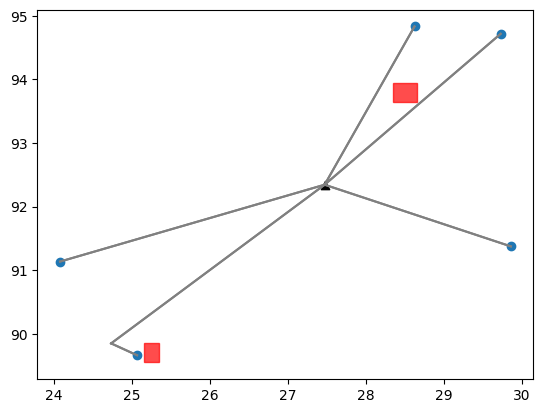

In [1600]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)